In [37]:
# TODO:
# clean up example from ch3 bollinger bands
# get more features, make sure working correctly, then use for 7.2, 7.3
# Get better text answers to 7.4, 7.5

import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing as mp
from pathlib import PurePath, Path
import pyarrow
import scipy.stats as stats
import scipy
from statsmodels.tsa.stattools import adfuller
import time
import sys


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold

from book_functions import *

importlib.reload(sys.modules['book_functions'])
# importlib.reload(sys.modules['sklearn'])

<module 'book_functions' from 'C:\\Users\\mlevy\\Workspace\\Advances-in-Financial-Machine-Learning\\book_functions.py'>

### 7.1
The purpose of shuffling for k-fold CV is that we want to remove any biases the data might have from its order. For example, say we collected data from multiple sources: s1, s2, s3. We want our model to generalize on all the data and not just find patterns depending on which data source it is from. By shuffling, we remove the dataset's arbitary biases/patterns and improve the models predictive ability to new data.  
Shuffling for financial data is generally a bad idea since it is temporal data and the sample order is meaningful. Financial data has memory in that it has predictive information in sequence. In addition, if we shuffle financial data, the data leakage will be even worse than it already is as the testing set will contain information from the testing set.  


In [8]:
# 7.2

data_f = PurePath('data/clean_IVE_ticks.parq')
df = pd.read_parquet(data_f)
print(df)

                        price     bid     ask   size      v            dv
dates                                                                    
2009-09-28 09:30:00   50.7900   50.70   50.79    100    100  5.079000e+03
2009-09-28 09:30:00   50.7100   50.70   50.79    638    638  3.235298e+04
2009-09-28 09:31:32   50.7500   50.75   50.76    100    100  5.075000e+03
2009-09-28 09:31:33   50.7500   50.72   50.75    100    100  5.075000e+03
2009-09-28 09:31:50   50.7500   50.73   50.76    300    300  1.522500e+04
2009-09-28 09:31:51   50.7500   50.74   50.76    300    300  1.522500e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    300    300  1.523400e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    500    500  2.539000e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    100    100  5.078000e+03
2009-09-28 09:32:56   50.8226   50.81   50.83    100    100  5.082260e+03
2009-09-28 09:33:02   50.8100   50.80   50.81    500    500  2.540500e+04
2009-09-28 09:33:02   50.8100   50.80 

In [9]:
# Create dollar bars

dol_col = df['dv']
dol = 0
dol_cutoff = 1_000_000
idx = []
for i, x in enumerate(dol_col):
    dol += x
    if dol >= dol_cutoff:
        idx.append(i)
        dol = 0
        
df_dol = df.iloc[idx].drop_duplicates().dropna()

In [10]:
close = df_dol.price.copy()
close = close[~close.index.duplicated()]

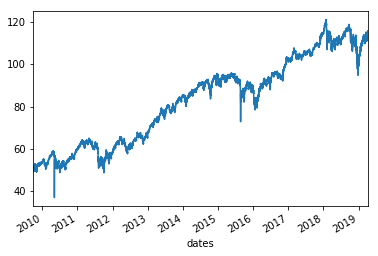

In [11]:
close.plot()

In [12]:
window = 500
num_std = 1
bol_df = pd.DataFrame().assign(price=close).assign(ma=close.rolling(window=window).mean())
std = close.rolling(window=window).std(ddof=0)
bol_df['high'] = bol_df.ma + num_std*std
bol_df['low'] = bol_df.ma - num_std*std

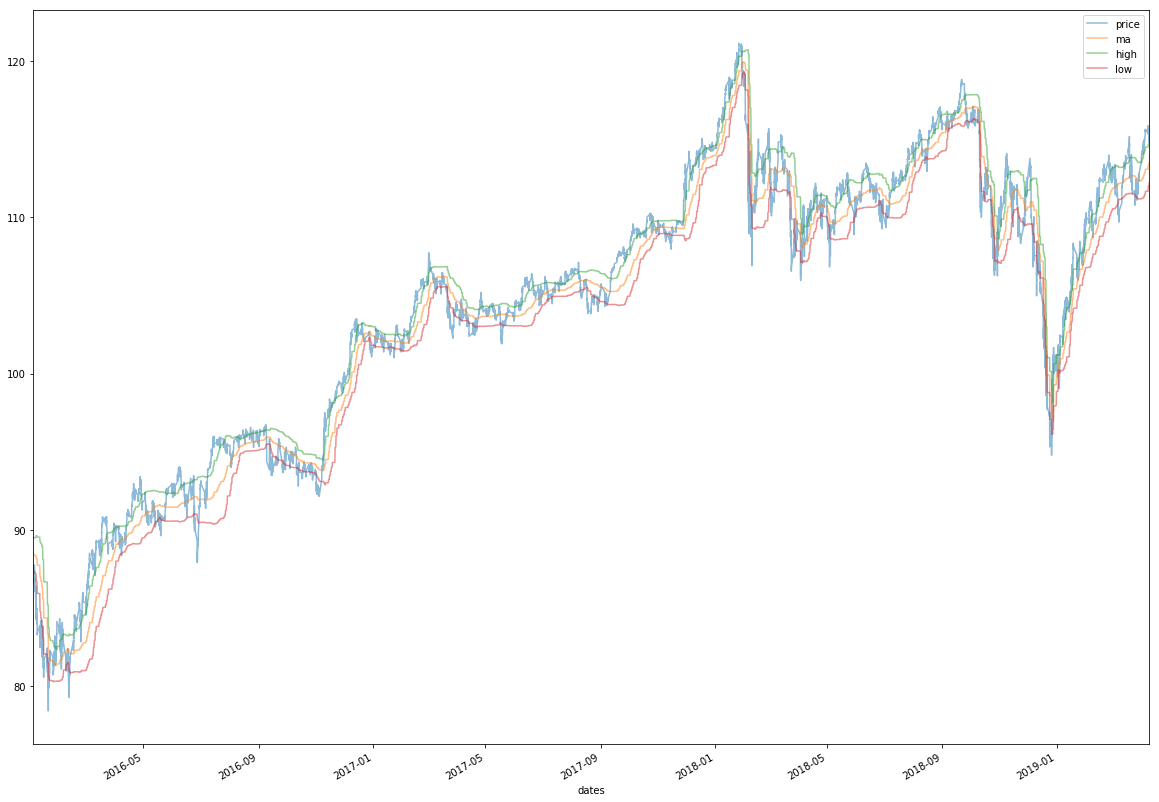

In [13]:
bol_df.loc['2016':].plot(figsize=(20, 15), alpha=.5)

In [14]:
def buySignal(df):
    cross = df.price < df.low
    # Check if this is first time crossing
    first_cross = df.price.shift(1) > df.low.shift(1)
    return df.price[cross & first_cross]

def sellSignal(df):
    cross = df.price > df.high
    first_cross = df.price.shift(1) < df.high.shift(1)
    return df.price[cross & first_cross]
    
buy_sig = buySignal(bol_df)
sell_sig = sellSignal(bol_df)

long = pd.Series(1, index=buy_sig.index)
short = pd.Series(-1, index=sell_sig.index)
side = pd.concat([short, long]).sort_index()  # each time we switch sides

dailyVol = getDailyVol(bol_df.price)
tEvents = getTEvents(bol_df.price, h=dailyVol.mean())
t1 = addVerticalBarrier(tEvents, bol_df.price, 1)

minRet = 0.005
numThreads = 1
ptSl = [0, 2]
# Determine which barrier hit first
events = getEvents(bol_df.price, tEvents, ptSl, dailyVol, minRet, numThreads, t1=t1, side=side)
labels = getBins_v2(events, bol_df.price).dropna()

C:\Users\mlevy\Workspace\Advances-in-Financial-Machine-Learning\book_functions.py:82: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  trgt = trgt.loc[tEvents]
C:\Users\mlevy\Workspace\Advances-in-Financial-Machine-Learning\book_functions.py:91: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  side_, ptSl_ = side.loc[trgt.index], ptSl[:2]
C:\Users\mlevy\Workspace\Advances-in-Financial-Machine-Learning\book_functions.py:161: RuntimeWarning: invalid value encountered in sign
  out['bin'] = np.sign(out['ret'])


In [16]:
# serial corr
ret_arr = np.diff(np.log(bol_df.price))
ret_s = pd.Series(ret_arr, index=bol_df.price.index[1:])
s_corr = ret_s.rolling(window=window).corr(ret_s.shift(1)).dropna()
features = pd.DataFrame().assign(vol=events.trgt).assign(s_corr=s_corr).drop_duplicates().dropna()


In [26]:
data_set = pd.merge_asof(features, labels[['bin']], left_index=True, right_index=True, 
                    direction='forward').dropna()
X = data_set.drop('bin', axis=1).values
y = data_set['bin'].values

t1 = events['t1'].loc[data_set.index]

In [42]:
data_set.head()

,vol,s_corr,bin
2009-11-12 10:10:39,0.010019,-0.121739,0.0
2009-11-12 10:45:45,0.009978,-0.120396,0.0
2009-11-12 11:24:37,0.009919,-0.121718,0.0
2009-11-12 12:11:10,0.009871,-0.121078,0.0
2009-11-12 12:57:30,0.009862,-0.120969,0.0


In [19]:
skf = StratifiedKFold(n_splits=10, shuffle=False, random_state=123)
clf = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=123)

In [20]:
accs = []
for train, test in skf.split(X, y):
    clf.fit(X[train], y[train])
    y_pred = clf.predict(X[test])
    acc = accuracy_score(y[test], y_pred)
    print(acc)
    accs.append(acc)
print('Mean accuracy: %f' % np.mean(accs))

0.5354265073631564
0.5307029730480689
0.5161200667037243
0.49972206781545303
0.41745414118954977
0.669816564758199
0.43829905503057254
0.49791492910758967
0.5276619405059773
0.5262718932443703
Mean accuracy: 0.515939


In [21]:
skf_shuffle = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

In [22]:
accs = []
for train, test in skf_shuffle.split(X, y):
    clf.fit(X[train], y[train])
    y_pred = clf.predict(X[test])
    acc = accuracy_score(y[test], y_pred)
    print(acc)
    accs.append(acc)
print('Mean accuracy: %f' % np.mean(accs))

0.5732147818838567
0.5671019727702139
0.5667037242912729
0.5689271817676487
0.5755975541967759
0.5647581989994441
0.5597554196775987
0.5638031693077564
0.5607450653322213
0.567139282735613
Mean accuracy: 0.566775


c) The results are fairly different as the shuffling K-Fold impl. increases our data leakage, hence we get an inflated accuracy score.  

d) Shuffling leaks information by increasing the overlapped data between training and test sets. Without shuffling, the only leaked data are data points at the index cutoff for each k-fold. By shuffling, we leak additional data which doesn't have to be only adjacent to the cutoff index. This allows for the algorithm to overfit.

In [38]:
# 7.3
skf_purge = PurgedKFold(n_splits=10,t1=t1,pctEmbargo=0.01)

In [47]:
data_set.drop(['bin'], axis=1, inplace=True)

In [49]:
accs = []
for train, test in skf_purge.split(data_set, y):
    clf.fit(X[train], y[train])
    y_pred = clf.predict(X[test])
    acc = accuracy_score(y[test], y_pred)
    print(acc)
    accs.append(acc)
print('Mean accuracy: %f' % np.mean(accs))

0.490550305725403
0.43718732629238466
0.42217898832684825
0.47998888271261814
0.508893829905503
0.48971650917176207
0.5019455252918288
0.4413563090605892
0.6637020566981656
0.7297748123436196
Mean accuracy: 0.516529


### 7.3b/c
b) Performance is lower since we purged labels that overlap test and training sets. In addition, we eliminated training set observations that immediately following an observation in testing set, since of the serial correlation present in our time series. This restricts the RF's ability from overfitting.  
c) We know this is a more realistic result since we have reduced our data leakage. In doing so, when our RF is less overfit and will perform better to out of sample data points.  


### 7.4
In addition to data leakage with k-fold CV in financial applciations, another issue arises since the testing set is used multiple times in process of developing a model, leading to multiple testing and selection bias (p.g. 104)  

### 7.5
a) Create a third set for after testing and training, to validate our results are not just a statistical fluke  
b) This holdout data set could fail if we run the model development many times on this validation set. Another issue could be if the holdout dataset is not representative of the entire data set.  
c) 